# Conditional Playback

In this tutorial we show how our Cluster Feedback capability (see section [Feedback](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/cluster/feedback.html)) can be used to send pulses dependent on the measurement outcome. Concretely, this tutorial will show how to perform active reset, which means sending a $\pi$-pulse if (and only if) the qubit state equals $\left|1\right\rangle$, to flip the qubit back to the $\left|0\right\rangle$ state.

This tutorial should be ran on a Cluster with at least two modules. A QRM or QRM-RF module is used to emulate qubit readout. For this tutorial we connect $\text{O}^{1}$ and $\text{O}^{2}$ to $\text{I}^{1}$ and $\text{I}^{2}$ of the QRM. Depending on the result acquired by this QRM, a second module (called QCM in this tutorial) is used to conditionally generate a $\pi$-pulse. The output of this QCM can be visualized on an oscilloscope to verify the behavior of the system.

To display the behaviour of the QRM, its marker 1 should be used to trigger an oscilloscope. Marker 2 and marker 4 need to be connected to the oscilloscope when running the section `Active reset`.

The tutorial will go through the following steps:
- Calibrate the time of flight (TOF) from QRM output to QRM input.
- Set up the thresholding to separate the $\left|0\right\rangle$ and $\left|1\right\rangle$ state.
- Sending the qubit state through the feedback infrastructure.
- Performing conditional pulses depending on the qubit state.

To synchronize the modules, we use the SYNQ technology, as demonstrated in the synchronization tutorial. We advise familiarizing yourself with that tutorial before continuing.

To run this tutorial please make sure you have installed and enabled ipywidgets:
```
pip install ipywidgets
jupyter nbextension enable --py widgetsnbextension
```

## Setup

First, we are going to import the required packages and connect to the instrument.

In [1]:
# Import ipython widgets

import contextlib

import ipywidgets as widgets
import matplotlib.pyplot as plt

# Set up the environment.
import numpy as np
from IPython.display import display
from qcodes import Instrument

from qblox_instruments import Cluster, PlugAndPlay

### Scan For Clusters

We scan for the available devices connected via ethernet using the Plug & Play functionality of the Qblox Instruments package (see [Plug & Play](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/api_reference/tools.html#api-pnp) for more info).

In [2]:
!qblox-pnp list

Devices:
 - 10.10.200.33: cluster_mm 0.4.0 with name "PE-Cluster" and serial number 00015_2321_004
 - 10.10.200.42: cluster_mm 0.6.1 with name "QAE_1" and serial number 00015_2320_004
 - 10.10.200.50: cluster_mm 0.6.1 with name "cluster-mm" and serial number 00015_2219_003
 - 10.10.200.51: pulsar_qcm 0.11.1 with name "pulsar-qcm" and serial number 00012_2039_005
 - 10.10.200.52: pulsar_qrm 0.11.1 with name "pulsar-qrm" and serial number 00013_2120_008
 - 10.10.200.53: cluster_mm 0.6.1 with name "cluster-mm" and serial number 00015_2320_003


In [3]:
cluster_ip = "10.10.200.42"
cluster_name = "cluster0"

### Connect to Cluster

We now make a connection with the Cluster.

In [4]:
from qblox_instruments import Cluster, ClusterType

try:  # Close the chosen QCodes instrument to prevent name clash
    Cluster.find_instrument(cluster_name).close()
except KeyError:
    pass

cluster = Cluster(
    name=cluster_name,
    identifier=cluster_ip,
    dummy_cfg={
        2: ClusterType.CLUSTER_QCM,
        4: ClusterType.CLUSTER_QRM,
        6: ClusterType.CLUSTER_QCM_RF,
        8: ClusterType.CLUSTER_QRM_RF,
    }
    if cluster_ip is None
    else None,
)

#### Get connected modules

In [5]:
def get_connected_modules(cluster, filter_fn=None):
    def checked_filter_fn(mod):
        if filter_fn is not None:
            return filter_fn(mod)
        return True

    return {
        mod.slot_idx: mod for mod in cluster.modules if mod.present() and checked_filter_fn(mod)
    }

In [6]:
# QRM baseband modules
readout_modules = get_connected_modules(cluster, lambda mod: mod.is_qrm_type and not mod.is_rf_type)
readout_modules

{4: <QcmQrm: cluster0_module4 of Cluster: cluster0>}

In [7]:
readout_module = readout_modules[4]

In [8]:
# QCM baseband modules
control_modules = get_connected_modules(
    cluster, lambda mod: not mod.is_qrm_type and not mod.is_rf_type
)
control_modules

{2: <QcmQrm: cluster0_module2 of Cluster: cluster0>}

In [9]:
control_module = control_modules[2]

## Sequencer configuration

Define all waveforms necessary for this tutorial

In [10]:
waveform_length = 120
t = np.arange(-80, 81, 1)
sigma = 20
# waveforms for readout pulses
waveforms = {
    "zero": {"data": [0.0] * 1024, "index": 0},
    "one": {"data": [1.0] * 1024, "index": 1},
    "state0_I": {
        "data": [0.001] * waveform_length,
        "index": 2,
    },  # I waveform emulating a qubit in the 0 state
    "state0_Q": {
        "data": [0.001] * waveform_length,
        "index": 3,
    },  # Q waveform emulating a qubit in the 0 state
    "state1_I": {
        "data": [0.001] * waveform_length,
        "index": 4,
    },  # I waveform emulating a qubit in the 1 state
    "state1_Q": {
        "data": [0.003] * waveform_length,
        "index": 5,
    },  # Q waveform emulating a qubit in the 1 state
    "gauss": {"data": list(np.exp(-(0.5 * t**2 / sigma**2))), "index": 6},
    "empty": {"data": list(0.0 * t), "index": 7},
}

Specify acquisitions that are used in the tutorial

In [11]:
acquisitions = {
    "state0": {"index": 0, "num_bins": 1024},
    "state1": {"index": 1, "num_bins": 1024},
    "single": {"index": 2, "num_bins": 1},
}

Set up sequencer parameters for both QRM and QCM

In [12]:
integration_length = 120
readout_module.sequencer0.integration_length_acq(integration_length)
readout_module.sequencer0.sync_en(True)
readout_module.sequencer0.nco_freq(50e6)
readout_module.sequencer0.mod_en_awg(True)
readout_module.sequencer0.demod_en_acq(True)

control_module.sequencer1.sync_en(False)  # We will turn on the sync enable of the QCM later
control_module.sequencer1.nco_freq(50e6)
control_module.sequencer1.mod_en_awg(True)

## Calibrate TOF

To ensure proper measurements, we must calibrate the time-of-flight (TOF). This is the time it takes for a signal to travel from the output to the input of the module. To do so, we first play an excitation pulse and acquire it back into

In [13]:
prog = """
play    1, 0, 4     # start readout pulse
acquire 2, 0, 16384 # start the 'single' acquisition sequence and wait for the length of the scope acquisition window
stop
"""

In [14]:
readout_module.sequencer0.sequence(
    {"waveforms": waveforms, "program": prog, "acquisitions": acquisitions, "weights": {}}
)

In [15]:
# Arm and start sequencer.
readout_module.arm_sequencer(0)
readout_module.start_sequencer()

# Wait for the sequencer and acquisition to finish with a timeout period of one minute.
readout_module.get_acquisition_state(0, 1)
readout_module.store_scope_acquisition(0, "single")
# Print status of sequencer.
print(readout_module.get_sequencer_state(0))

Status: STOPPED, Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE


In [16]:
p0 = np.array(readout_module.get_acquisitions(0)["single"]["acquisition"]["scope"]["path0"]["data"])
p1 = np.array(readout_module.get_acquisitions(0)["single"]["acquisition"]["scope"]["path1"]["data"])
# Determine when the signal crosses half-max for the first time (in ns)
t_halfmax = np.where(np.abs(p0) > np.max(p0) / 2)[0][0]

# The time it takes for a sine wave to reach its half-max value is (in ns)
correction = 1 / readout_module.sequencer0.nco_freq() * 1e9 / 12

tof_measured = t_halfmax - correction

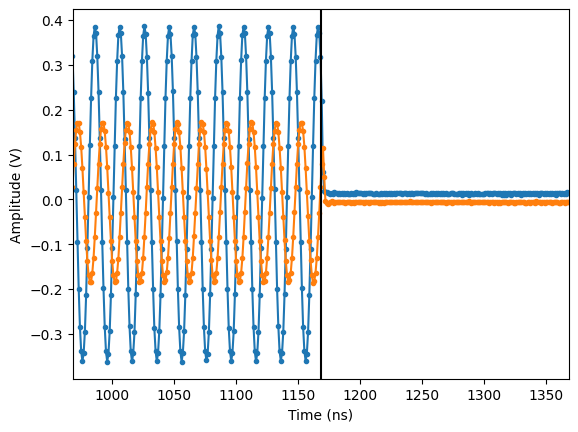

In [17]:
r = readout_module.get_acquisitions(0)["single"]["acquisition"]["scope"]
plt.plot(r["path0"]["data"], ".-")
plt.plot(r["path1"]["data"], ".-")
plt.axvline(tof_measured, c="k")
plt.xlim(
    tof_measured - 10 / readout_module.sequencer0.nco_freq() * 1e9,
    tof_measured + 10 / readout_module.sequencer0.nco_freq() * 1e9,
)
plt.ylabel("Amplitude (V)")
plt.xlabel("Time (ns)")
plt.show()

plt.plot(r["path0"]["data"], ".-")
plt.plot(r["path1"]["data"], ".-")
plt.axvline(1024 + tof_measured, c="k")
plt.xlim(
    1024 + tof_measured - 10 / readout_module.sequencer0.nco_freq() * 1e9,
    1024 + tof_measured + 10 / readout_module.sequencer0.nco_freq() * 1e9,
)
plt.ylabel("Amplitude (V)")
plt.xlabel("Time (ns)")
plt.show()

In [18]:
tof = int(tof_measured)  # time of flight must be an integer
print("Measured TOF:", tof_measured)
print("Rounded TOF: ", tof)

Measured TOF: 144.33333333333334
Rounded TOF:  144


## Measure qubit histogram

In [19]:
prog = f"""
    move 0, R0
    start: set_mrk 1
    play 2, 3, {tof}
    acquire 0, R0, 120
    play 4, 5, {tof}
    acquire 1, R0, 120
    add R0, 1, R0
    wait 4000
    jlt R0, 1024, @start
    set_mrk 0
    upd_param 4
    stop
"""

In [20]:
readout_module.sequencer0.sequence(
    {"waveforms": waveforms, "program": prog, "acquisitions": acquisitions, "weights": {}}
)

In [21]:
readout_module.sequencer0.arm_sequencer()
readout_module.sequencer0.start_sequencer()
print(readout_module.sequencer0.get_sequencer_state(1))

Status: STOPPED, Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE


In [22]:
readout_module.sequencer0.get_acquisition_state(1)
data = readout_module.sequencer0.get_acquisitions()

In [23]:
state0 = np.array(data["state0"]["acquisition"]["bins"]["integration"]["path0"]) + 1j * np.array(
    data["state0"]["acquisition"]["bins"]["integration"]["path1"]
)
state1 = np.array(data["state1"]["acquisition"]["bins"]["integration"]["path0"]) + 1j * np.array(
    data["state1"]["acquisition"]["bins"]["integration"]["path1"]
)

Given this data, we can now determine the rotation and thresholding values to discriminate the $\left|0\right\rangle$ state from the $\left|1\right\rangle$ state.

In [24]:
rotation = np.mod(-np.angle(np.mean(state1) - np.mean(state0)), 2 * np.pi)
threshold = (np.exp(1j * rotation) * (np.mean(state1) + np.mean(state0))).real / 2

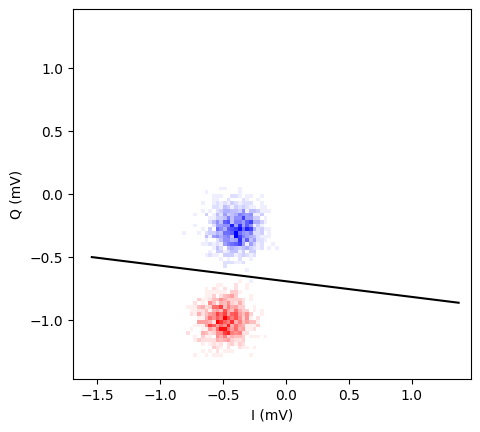

In [25]:
scaling = 1000 / integration_length
maxr = max(np.max(np.abs(state0)), np.max(np.abs(state1)))
hist0, xedges, yedges = np.histogram2d(
    state0.real, state0.imag, range=((-maxr, maxr), (-maxr, maxr)), bins=100
)
hist1, xedges, yedges = np.histogram2d(
    state1.real, state1.imag, range=((-maxr, maxr), (-maxr, maxr)), bins=100
)

plt.imshow(
    1 - np.array((hist0, hist0 + hist1, hist1)).transpose(2, 1, 0) / np.max(hist0 + hist1),
    extent=(-maxr * scaling, maxr * scaling, -maxr * scaling, maxr * scaling),
    origin="lower",
)
plt.plot(
    ((1j * xedges + threshold) * np.exp(-1j * rotation)).real * scaling,
    ((1j * xedges + threshold) * np.exp(-1j * rotation)).imag * scaling,
    "k",
)
plt.xlabel("I (mV)")
plt.ylabel("Q (mV)")
plt.show()

In [26]:
readout_module.sequencer0.thresholded_acq_threshold(threshold)
readout_module.sequencer0.thresholded_acq_rotation(rotation * 360 / (2 * np.pi))

Now that the rotation and thresholding values are programmed into the QRM module, the module will automatically assign a qubit state to every acquisition. By running the same sequence as before, we can check the the module is assigning the correct state to the qubit.

In [27]:
readout_module.sequencer0.delete_acquisition_data(all=True)
readout_module.sequencer0.arm_sequencer()
readout_module.sequencer0.start_sequencer()
print(readout_module.sequencer0.get_sequencer_state(1))

Status: STOPPED, Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE


In [28]:
readout_module.sequencer0.get_acquisition_state(1)
data = readout_module.sequencer0.get_acquisitions()

To check that the assignments are made correctly, we calculate the confusion matrix.

In [29]:
confusion_matrix = [
    [
        np.sum(np.array(data["state0"]["acquisition"]["bins"]["threshold"]) == 0),
        np.sum(np.array(data["state0"]["acquisition"]["bins"]["threshold"]) == 1),
    ],
    [
        np.sum(np.array(data["state1"]["acquisition"]["bins"]["threshold"]) == 0),
        np.sum(np.array(data["state1"]["acquisition"]["bins"]["threshold"]) == 1),
    ],
]

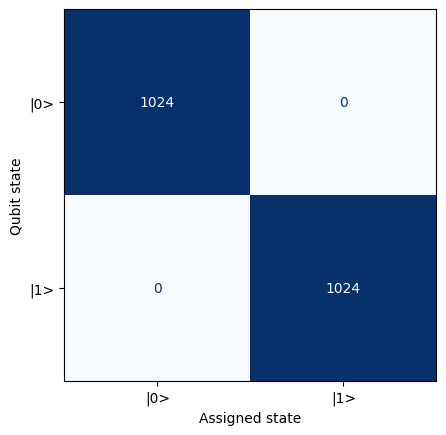

In [30]:
p = plt.matshow(confusion_matrix, cmap="Blues", vmin=0, vmax=1024)
ax = plt.gca()
for i in [0, 1]:
    for j in [0, 1]:
        ax.annotate(
            confusion_matrix[i][j],
            xy=(j, i),
            horizontalalignment="center",
            verticalalignment="center",
            color=p.cmap(1024 - confusion_matrix[i][j]),
        )
plt.xlabel("Assigned state")
plt.ylabel("Qubit state")
plt.xticks([0, 1], ["|0>", "|1>"])
plt.yticks([0, 1], ["|0>", "|1>"])
ax.xaxis.set_ticks_position("bottom")
plt.show()

## Sending results on the trigger network

Now that the module can correctly identify the qubit state, we want to send this result to all other modules in the Cluster. Hence we must enable this functionality and specify an address used for sending these triggers. In this tutorial, we will only use address 1. Note that only one trigger can be sent simultaneously, even if the address is different.

In [31]:
readout_module.sequencer0.thresholded_acq_trigger_address(1)
readout_module.sequencer0.thresholded_acq_trigger_en(True)

To verify that the correct triggers are being sent, we can use the trigger monitor. This monitor can be reset with the following command:

In [32]:
cluster.reset_trigger_monitor_count(address=1)

Such that the monitor reports both a total trigger count of 0 and no latest trigger (also represented by the value 0)

In [33]:
cluster.trigger1_monitor_count(), cluster.trigger_monitor_latest()

(0, 1)

Now, to verify the Cluster is configured correctly, let us run the above program one more time:

In [34]:
readout_module.sequencer0.delete_acquisition_data(all=True)
readout_module.sequencer0.arm_sequencer()
readout_module.sequencer0.start_sequencer()
readout_module.sequencer0.get_sequencer_state(1)
readout_module.sequencer0.get_acquisition_state(1)
data = readout_module.sequencer0.get_acquisitions()

The number of triggers received by the monitor should be equal to the number of measurements that have been classified as the $\left|1\right\rangle$ state.

In [35]:
print(
    "Acquisition:",
    np.sum(np.array(data["state0"]["acquisition"]["bins"]["threshold"]) == 1)
    + np.sum(np.array(data["state1"]["acquisition"]["bins"]["threshold"]) == 1),
)
print("Monitor:    ", cluster.trigger1_monitor_count())

Acquisition: 1024
Monitor:     1024


The most recent trigger that has been received should now be equal to 1.

In [36]:
cluster.trigger_monitor_latest()

1

Besides investigating the sent triggers using this monitor, it can be convenient to visualize the triggers on an oscilloscope as they are being sent. In order the enable sending the trigger on marker 4, use the following commands. Enabling triggers on the marker outputs can also be used to control external equipment based on the measurement results.

In [37]:
readout_module.sequencer0.thresholded_acq_marker_en(True)
readout_module.sequencer0.thresholded_acq_marker_address(8)

Now connect your marker output 4 to the oscilloscope and run the following cell.

In [38]:
readout_module.sequencer0.arm_sequencer()
readout_module.sequencer0.start_sequencer()

The following image can be obtained on the oscilloscope (C1 (yellow) is the marker 1 output whereas C3(blue) is marker 4 output:

![SDS6204A_PNG_5 (2).png](9d786b40-430b-47ab-9721-94f3e25fd196.png)

## Active reset

As the final part of this tutorial, we will show how the triggers we have been generating above, can be used to affect the behavior of other sequencers in the Cluster. We will show this capability using a active reset protocol as an example. Basically, in order to perform active reset on a qubit, we must first measure the qubit state, and if the state equals $\left|1\right\rangle$, we must play a $\pi$-pulse to flip the qubit back to the $\left|0\right\rangle$ state.

In a real qubit setup, the QRM would play identical readout pulses and the actual qubit state would influence the acquisition result. For this tutorial, in lieu of a qubit, we determine the qubit state results in advance for the QRM, and play a different waveform depending on this pre-determined state. To still properly demonstrate the feedback capability, we ensure that the QCM is not aware of the pre-determined choices in advance, as it can figure out from the acquisitions results whether it should play a $\pi$-pulse.

Generate 100 random qubit states:

In [39]:
length = 100
states = np.random.choice(2, length)
states

array([0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0])

For the QRM program, this means playing waveforms `'state0_I'` and `'state0_Q'` if the qubit state has to appear as $\left|0\right\rangle$ while playing waveforms `'state1_I'` and `'state1_Q'` if the qubit state has to appear as $\left|1\right\rangle$.

In [40]:
qrm_prog = """
wait_sync 4
set_mrk 1
upd_param 1000
move 0, R0
"""
for s in states:
    if s == 1:
        qrm_prog += f"""set_mrk 3
        play 4, 5, {tof}
        set_mrk 1"""
    else:
        qrm_prog += f"play 2, 3, {tof}"
    qrm_prog += """
    acquire 0, R0, 120
    wait 1000
    """
qrm_prog += """set_mrk 0
upd_param 1000
stop"""

So, in order to achieve feedback from the QRM module, we only had to set the thresholding and trigger parameters without any changes to the Q1ASM program. On the receiving side, for the QCM, the feedback is controlled via Q1ASM, however. Let's build up the program step by step.

First, we need to tell the module to listen for triggers on address 1 with:

In [41]:
qcm_prog = "set_latch_en 1, 4     # Enabling listening to triggers on address 1"

We can then sync with the other module and program our loop:

In [42]:
qcm_prog += f"""
wait_sync 4
wait 1000
move {len(states)}, R0
s:
"""
# Here we need to write the code to receive and react to triggers
# Therefore, we store then end of the program in a separate variable for now
qcm_prog_tail = """
loop R0, @s
stop
"""

For every iteration of our loop, we first need to clear any received triggers and then wait for any new trigger to come in:

In [43]:
qcm_prog += f"""
latch_rst {tof+120}   # Deletes all previously received triggers
wait      300         # gives the acquisition result time to be received by the QCM
"""

Next, we program a conditional play instruction. In order to mark a `play`, `acquire`, `acquire_weighed` or `wait` instruction as conditional, we open a conditionality block using the `set_cond <enable> <address_mask> <operator> <else_wait>` instruction.

The `<enable>` argument sets whether subsequent real-time pipeline instructions are conditional or not. In case a conditional instruction is skipped, the `<else_wait>` argument determines how long the real-time pipeline will stall (minimum is 4 ns).

The `<address_mask>` and `<operator>` determine the conditionality, if the condition evaluates to `True` the instruction es executed, otherwise the instruction will be skipped (equivalent to a `wait <else_wait>` instruction).

When only listening to a single trigger address, the `<address mask>` should be made equal to `2**(address-1)` and the `<operator>` should be `0` for `OR` or `2` for `AND` (both having the same effect for a single input, feedback based on multiple trigger addresses is not covered in this tutorial). To invert the conditional, `<operator>` `1` for `NOR` or `3` for `NAND` can be used.

For active reset, we can enable the conditional with:

In [44]:
qcm_prog += """
set_cond 1, 1, 0, 700 # Enable conditional commands
"""

Next we can invoke our play command as usual:

In [45]:
# print(qrm_prog)

In [46]:
qcm_prog += "play 6, 7, 700"

Finally, do not forget to disable the conditional commands again (after the first `0`, the parameters do not matter):

In [47]:
qcm_prog += (
    """
set_cond 0, 1, 0, 700 # Disable conditional commands again
"""
    + qcm_prog_tail
)

In summary, the complete QCM program is:

In [48]:
print(qcm_prog)

set_latch_en 1, 4     # Enabling listening to triggers on address 1
wait_sync 4
wait 1000
move 100, R0
s:

latch_rst 264   # Deletes all previously received triggers
wait      300         # gives the acquisition result time to be received by the QCM

set_cond 1, 1, 0, 700 # Enable conditional commands
play 6, 7, 700
set_cond 0, 1, 0, 700 # Disable conditional commands again

loop R0, @s
stop



In [49]:
control_module.sequencer1.sync_en(True)  # We did not enable the sync on the QCM sequencer yet

readout_module.sequencer0.sequence(
    {"waveforms": waveforms, "program": qrm_prog, "acquisitions": acquisitions, "weights": {}}
)
readout_module.sequencer0.arm_sequencer()

control_module.sequencer1.sequence(
    {"waveforms": waveforms, "program": qcm_prog, "acquisitions": acquisitions, "weights": {}}
)
control_module.sequencer1.arm_sequencer()

We are all set to witness the conditional playback! Please make sure that you have connected the QCM output 0 to the oscilloscope along with the marker 1 of QRM as trigger and marker 4.

In [50]:
readout_module.start_sequencer()
control_module.start_sequencer()

In [51]:
print("QRM:")
print(readout_module.get_sequencer_state(0, 1))
print("QCM:")
print(control_module.get_sequencer_state(0, 1))

QRM:
Status: STOPPED, Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE
QCM:
Status: STOPPED, Flags: NONE


On the oscilloscope, you should see an image as below (CH1 (yellow) : Marker 1, CH2 (pink): Marker 2, CH3(blue) : QCM Output 0, CH4(green) : Marker 4). Marker 2 activation corresponds to a state 1 signal by QRM which is confirmed by the Marker 4


![image.png](5a08cf99-6cfa-49a0-94c7-accea41f8c21.png)

## Stop

In [52]:
# Stop sequencers.
control_module.stop_sequencer()
readout_module.stop_sequencer()

# Print status of sequencers.
print("QCM :")
print(control_module.get_sequencer_state(0))
print()

print("QRM :")
print(readout_module.get_sequencer_state(0))
print()

# Reset the cluster
cluster.reset()
print(cluster.get_system_state())

QCM :
Status: STOPPED, Flags: NONE

QRM :
Status: STOPPED, Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE



Status: OKAY, Flags: NONE, Slot flags: NONE
